In [94]:
import pandas as pd
tweets = pd.read_csv('2016_US_election_tweets_100k.csv')
# https://data.world/alexfilatov/2016-usa-presidential-election-tweets

In [256]:
tweets2 = pd.read_csv('2016_US_election_tweets_100k.csv')
tweets2.columns

Index(['id', 'candidate_id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'tweet_text', 'created_at', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude'],
      dtype='object')

In [268]:
pd.to_datetime(tweets2['created_at']).dt.date.value_counts()

2016-08-31    41580
2016-08-30    35396
2016-09-01    11964
2017-02-17    11060
Name: created_at, dtype: int64

In [270]:
tweets2['candidate_id'].value_counts()

2    66899
1    25549
3     7527
4       25
Name: candidate_id, dtype: int64

In [95]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk

tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets = tweets.dropna(subset=['tweet_text'])
tweets['cleaned_tweet_text'] = tweets['tweet_text'].str.lower().str.replace('[^\w\s]', '', regex=True)


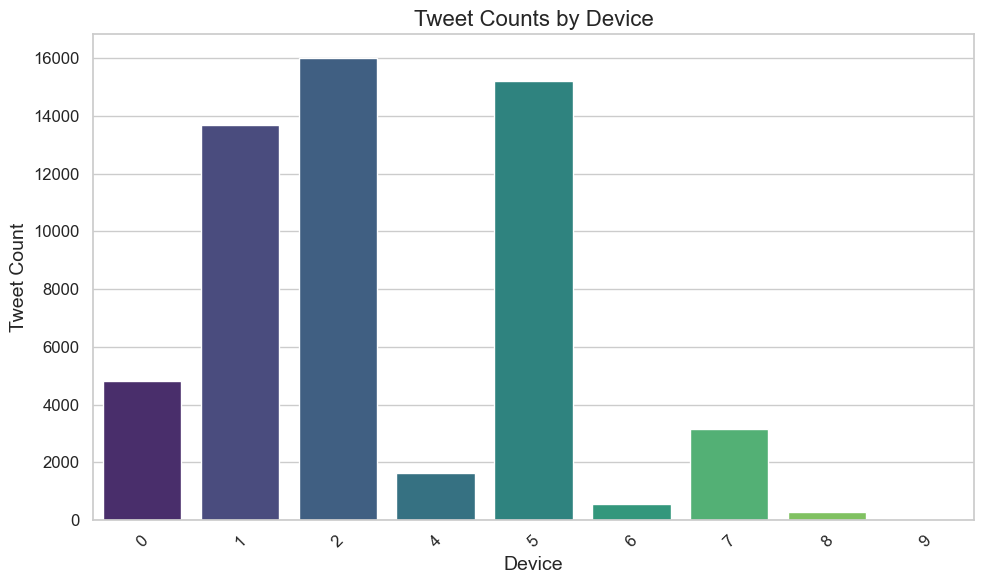

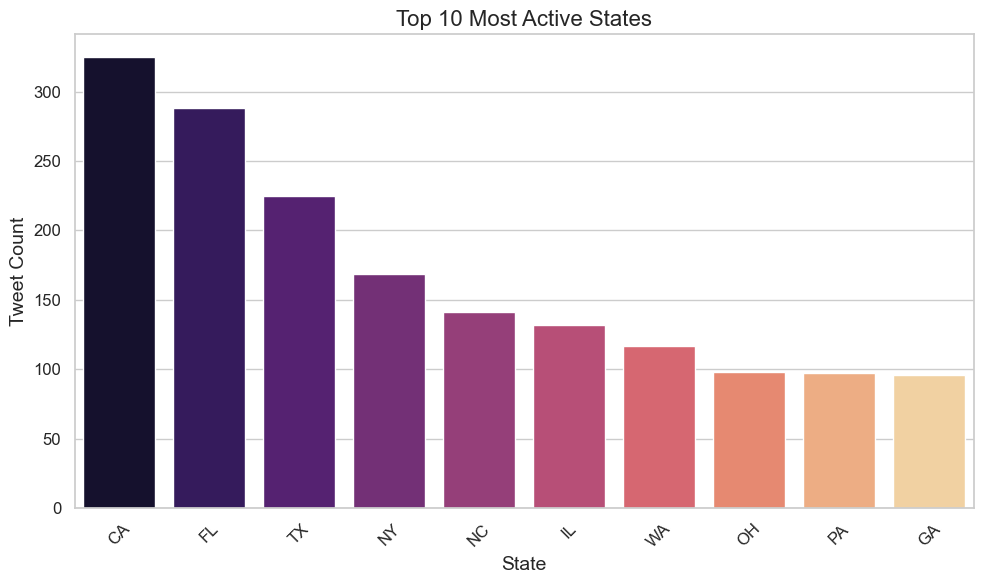

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
device_counts = tweets['device'].value_counts()
sns.barplot(x=device_counts.index, y=device_counts.values, palette="viridis")
plt.title('Tweet Counts by Device', fontsize=16)
plt.xlabel('Device', fontsize=14)
plt.ylabel('Tweet Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
top_states = tweets['state'].value_counts().head(10)
sns.barplot(x=top_states.index, y=top_states.values, palette="magma")
plt.title('Top 10 Most Active States', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Tweet Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


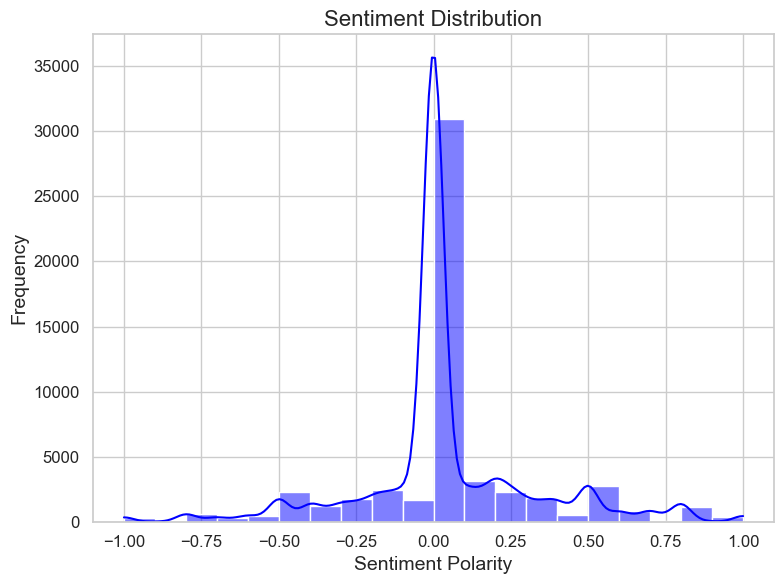

In [119]:
plt.figure(figsize=(8, 6))
sns.histplot(tweets['sentiment'], bins=20, kde=True, color='blue')
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
tweets.columns

Index(['id', 'candidate_id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'tweet_text', 'created_at', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude',
       'cleaned_tweet_text'],
      dtype='object')

In [99]:
from googletrans import Translator
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def translate_text_batch(texts):
    translator = Translator()
    try:
        translations = translator.translate(texts, dest='en')
        return [translation.text for translation in translations]
    except Exception as e:
        return texts  

def translate_in_batches(texts, batch_size=100):
    translated_texts = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            futures.append(executor.submit(translate_text_batch, batch))
        
        for future in as_completed(futures):
            translated_texts.extend(future.result())
    return translated_texts

tweets['subset_translated'] = translate_in_batches(tweets['cleaned_tweet_text'].tolist(), batch_size=100)

print("\nTranslation completed!")



Translation completed!


In [105]:
tweets['subset_translated']

0                                                      NaN
1                                                      NaN
2        white house taking tax avoid seriously apple d...
3                                                      NaN
4                     shes due 250 days httpstcoifoo99rye5
                               ...                        
99995                                                  NaN
99996    realdonaldtrump least hes record denying russi...
99997                                                  NaN
99998                                                  NaN
99999                                                  NaN
Name: subset_translated, Length: 55393, dtype: object

In [265]:
tweets.to_csv('modified_tweets.csv')

In [107]:
tweets.loc[tweets['polarity'] < 0, 'subset_translated']

2        white house taking tax avoid seriously apple d...
4                     shes due 250 days httpstcoifoo99rye5
7        wsj report results election day polls dont mea...
26       youcancallmefee clinton trump hillaryclinton r...
30       politico realdonaldtrump hillaryclinton got fi...
                               ...                        
99975    djtmovement cbs cnn abc nbc msnbc potus realdo...
99978    realdonaldtrump thread reading everyone laughi...
99989                  maybe isnt crazy httpstcok7xid7cpct
99994             news fake much news fake realdonaldtrump
99996    realdonaldtrump least hes record denying russi...
Name: subset_translated, Length: 11134, dtype: object

In [108]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tweets.loc[tweets['polarity'] < 0, 'subset_translated'] = tweets.loc[tweets['polarity'] < 0, 'subset_translated'].apply(
    lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words))
tweets['subset_translated'].dropna(inplace=True)

vec = CountVectorizer(max_features=1000)
X = vec.fit_transform(tweets.loc[tweets['polarity'] < 0, 'subset_translated'])

# fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vec.get_feature_names_out(), 10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/susanliang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
barackobama realdonaldtrump bad hillaryclinton obama potus amp crazy realdonaldtrumps know
Topic 1:
realdonaldtrump hillaryclinton hillary trump amp clinton thats hate evil hrc
Topic 2:
realdonaldtrump trump donald cnn like long one support seanhannity thank
Topic 3:
realdonaldtrump hillaryclinton vote mexico wall barackobama dont want going would
Topic 4:
realdonaldtrump illegal go hillaryclinton press help military immigration trumps conference
Topic 5:
realdonaldtrump stupid black people fuck idiot hes youre fucking like
Topic 6:
realdonaldtrump president shit dont know youre worst sad people one
Topic 7:
hillaryclinton realdonaldtrump time mental health hard money amp plan us
Topic 8:
realdonaldtrump hillaryclinton rush amp look corrupt could limbaugh msnbc watch
Topic 9:
fake realdonaldtrump news media hillaryclinton get every thing work stop


In [210]:
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

def preprocess_text(text):
    if isinstance(text, str):  
        custom_stop_words = ['https', 'you', 't', 'co', 'for', 'hillary', 'on', 'with', 'realDonaldTrump', 'HillaryClinton', 'trump', 'u', 'will', 'amp', 'say', 'think', 'know', 'fuck', 'one', 'people']
        meaningless_tokens = ['el', 'en', 'los', "n't", "'s", "``", 'de', '2', "'s", '..', 'amp', 'un', 'la', 'es', 'que', '3', "''"]  
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token not in stop_words and token not in punctuation and token not in custom_stop_words and token not in meaningless_tokens]
        return tokens
    else:
        return [] 

tweets_filtered = tweets.dropna(subset=['tweet_text']).copy()
# 1 hillary
# 2 Trump

tweets_filtered = tweets_filtered[(tweets_filtered['polarity'] < -0.1) & 
                                  (tweets_filtered['lang'] == 'en') & 
                                  (tweets_filtered['subjectivity'] > 0)&
                                  (tweets_filtered['candidate_id'] == 1)]

tweets_filtered['preprocessed_text'] = tweets_filtered['tweet_text'].apply(preprocess_text)
dictionary = Dictionary(tweets_filtered['preprocessed_text'])
dictionary.filter_extremes(no_below=5, no_above=0.4)
corpus = [dictionary.doc2bow(text) for text in tweets_filtered['preprocessed_text']]

# Train LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=10)

for idx, topic in lda_model.print_topics():
    print("Topic {}: {}".format(idx, topic))

coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets_filtered['preprocessed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Topic 0: 0.038*"politico" + 0.034*"hard" + 0.030*"enemy" + 0.029*"see" + 0.027*"failed" + 0.024*"'ll" + 0.023*"clintonfdn" + 0.023*"bernie" + 0.021*"timkaine" + 0.021*"ppl"
Topic 1: 0.103*"realdonaldtrump" + 0.037*"cnn" + 0.031*"like" + 0.030*"msnbc" + 0.029*"mlauer" + 0.029*"would" + 0.028*"us" + 0.025*"shit" + 0.023*"get" + 0.020*"show"
Topic 2: 0.046*"poor" + 0.024*"country" + 0.024*"news" + 0.021*"fraud" + 0.020*"guy" + 0.018*"ago" + 0.018*"1" + 0.018*"far" + 0.015*"dangerous" + 0.015*"polls"
Topic 3: 0.068*"illegal" + 0.051*"immigrants" + 0.028*"ask" + 0.026*"crooked" + 0.026*"corruption" + 0.025*"mexico" + 0.023*"world" + 0.021*"..." + 0.021*"desperate" + 0.019*"calling"
Topic 4: 0.045*"least" + 0.041*"sorry" + 0.031*"need" + 0.030*"idiot" + 0.030*"endless" + 0.026*"ass" + 0.024*"could" + 0.024*"voters" + 0.023*"stand" + 0.022*"truth"
Topic 5: 0.052*"go" + 0.048*"realdonaldtrump" + 0.039*"another" + 0.035*"video" + 0.033*"economic" + 0.031*"fucking" + 0.029*"imwithher" + 0.025*"h

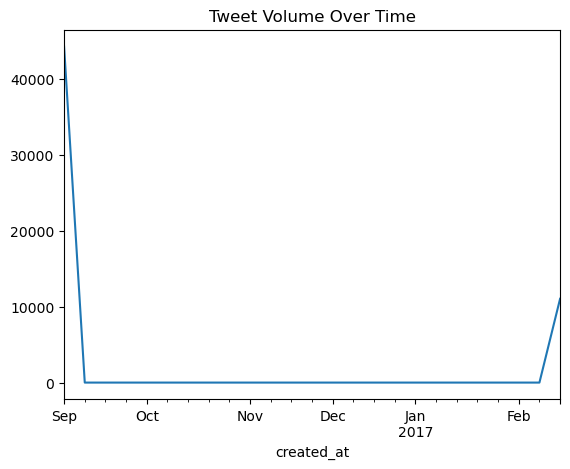

In [47]:
# Tweets over time
tweets.set_index('created_at')['id'].resample('W').count().plot()
plt.title('Tweet Volume Over Time')
plt.show()


In [39]:
import networkx as nx
G = nx.DiGraph()
tweets_re = tweets[pd.notnull(tweets['retweeted_status_id'])]
for index, row in tweets_re.iterrows():
    if pd.notna(row['retweeted_status_id']):
        G.add_edge(row['tw_user_id'], row['retweeted_status_id'])
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 55913
Number of edges: 44607


In [66]:
tweets.loc[tweets['polarity'] < 0, 'tweet_text'].dropna().tolist()

['White house not taking tax avoid seriously! Apple disgusting. @BarackObama #AppleTax',
 "She's over due by 250 days. https://t.co/IfOO99rYE5",
 "@WSJ can we just report the results after Election Day. Polls don't mean anything in this election and @HillaryClinton is a corrupt liar.",
 '@youcancallmefee Clinton /Trump @HillaryClinton @realDonaldTrump sorry not sorry',
 '@politico @realDonaldTrump @HillaryClinton I got five bucks Trump tweets something stupid anway.',
 '@WhoisNeil__ @realDonaldTrump @vine WRONG!',
 "@ryangrim @realDonaldTrump @itsmarlamaples this just dumb. You're allowing yourself to lose credibility with your horrible pieces. Just dumb",
 'Also need to add @realDonaldTrump to this list.... Stupid bitch https://t.co/SSPJvJzr8c',
 "Why are you going to show us your TAX RETURNS? If not it's not worth going to..Bunch of dumb down idiots who know 0. https://t.co/a9uZBrH21D",
 'HE DEADASS JUST PROVED THAT HE HATES MEXICANS I WANT HIM DEAD https://t.co/WLz1DVu1dX',
 '@Hilla

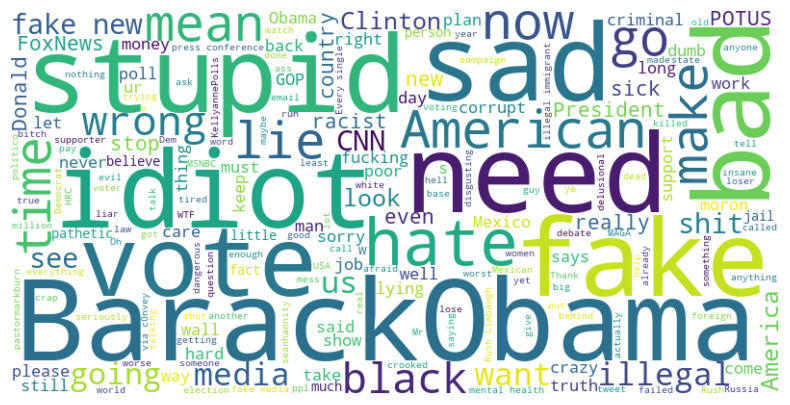

In [90]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

custom_stop_words = ['https', 'you', 't', 'co', 'for', 'hillary', 'on', 'with', 'realDonaldTrump', 'HillaryClinton', 'trump', 'u', 'will', 'amp', 'say', 'think', 'know', 'fuck', 'one', 'people']
stop_words = set(STOPWORDS)
stop_words.update(custom_stop_words)
negative_tweets = tweets[tweets['polarity'] < 0]
text = ' '.join(negative_tweets['tweet_text'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [127]:
tweets['created_at'].max()

Timestamp('2017-02-17 14:21:07')

In [128]:
tweets['created_at'].min()

Timestamp('2016-08-30 20:50:30')

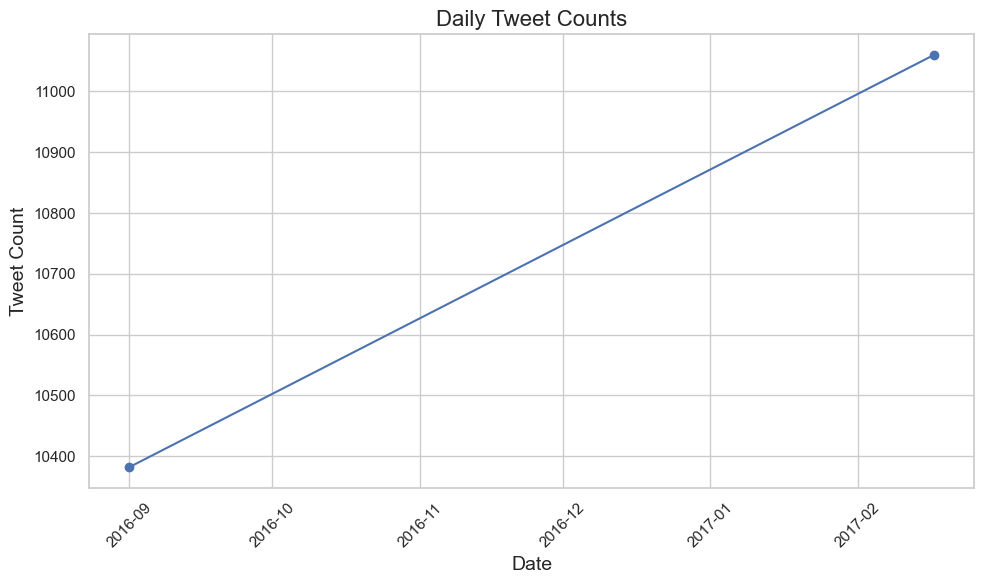

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

tweets['date'] = tweets['created_at'].dt.date
daily_tweet_counts = tweets['date'].value_counts().sort_index()[2:]
plt.figure(figsize=(10, 6))
plt.plot(daily_tweet_counts.index, daily_tweet_counts.values, marker='o', linestyle='-')
plt.title('Daily Tweet Counts', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Tweet Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


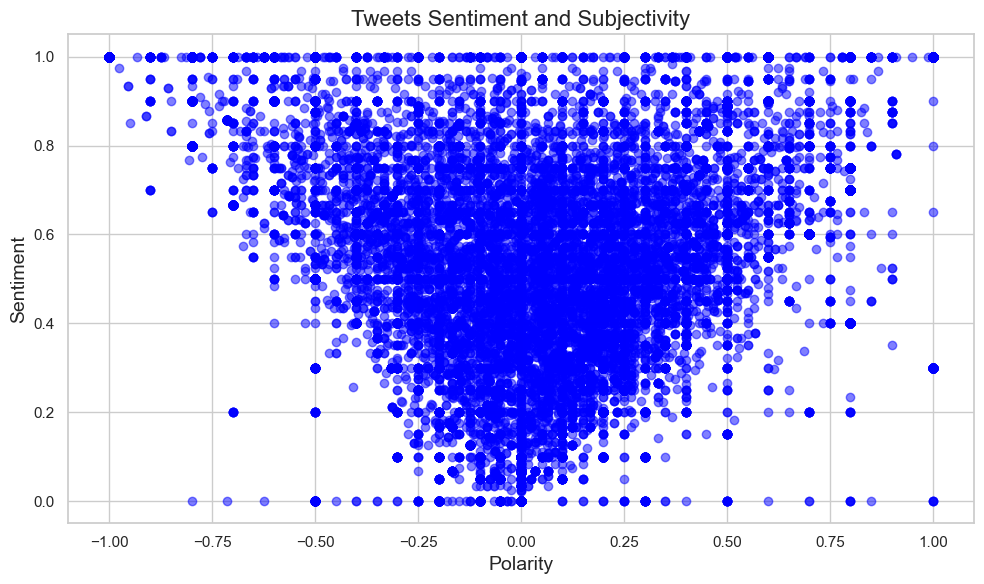

In [153]:
plt.figure(figsize=(10, 6))
plt.scatter(tweets['sentiment'], tweets['subjectivity'], color='blue', alpha=0.5)
plt.title('Tweets Sentiment and Subjectivity', fontsize=16)
plt.xlabel('Polarity', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [213]:
tweets['state'] = tweets['state'].str.upper()
us_state_abbr = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME',
    'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
    'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
tweets_filtered = tweets[tweets['state'].isin(us_state_abbr)]
average_polarity_by_state = tweets_filtered.groupby('state')['polarity'].mean().reset_index()


In [220]:
average_polarity_by_state_candidate = tweets_filtered.groupby(['state', 'candidate_id'])['polarity'].mean().reset_index()


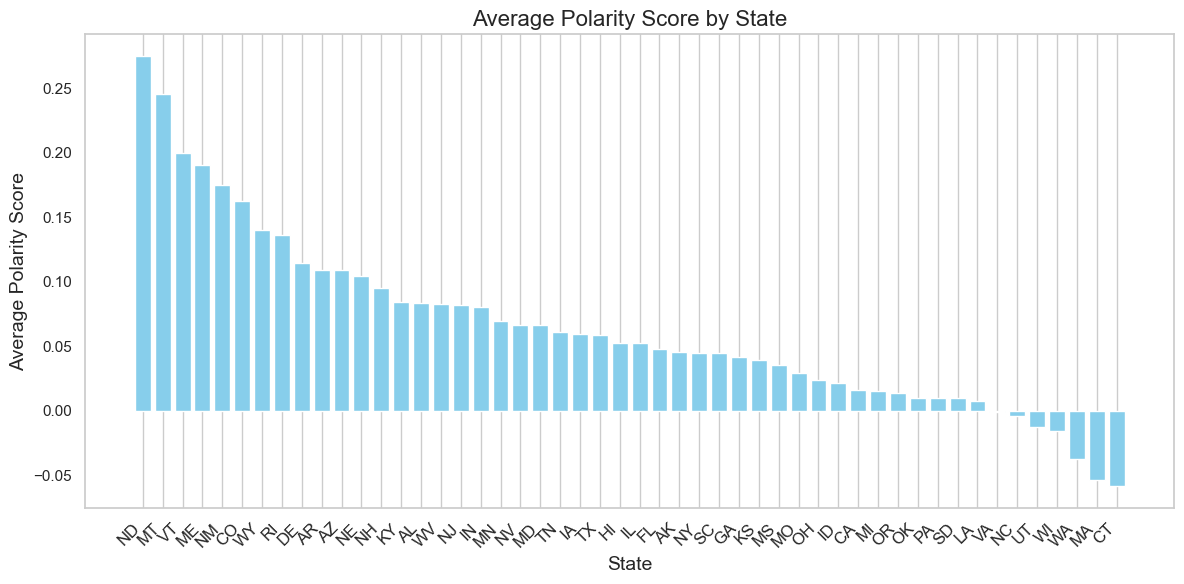

In [170]:
average_polarity_by_state_sorted_full = average_polarity_by_state.sort_values(by='polarity', ascending=False)
average_polarity_by_state_sorted = average_polarity_by_state_sorted_full
plt.figure(figsize=(12, 6))
plt.bar(average_polarity_by_state_sorted['state'], average_polarity_by_state_sorted['polarity'], color='skyblue')
plt.title('Average Polarity Score by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Polarity Score', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [222]:
average_polarity_by_state_candidate

,state,candidate_id,polarity
0,AK,1,0.000000
1,AK,2,0.056458
2,AL,1,0.212500
3,AL,2,0.080412
4,AL,3,0.000000
...,...,...,...
123,WI,2,-0.121261
124,WV,1,0.000000
125,WV,2,0.094577
126,WY,1,0.800000


In [230]:
tweets['candidate_id'].value_counts()

2    36712
1    14290
3     4366
4       25
Name: candidate_id, dtype: int64

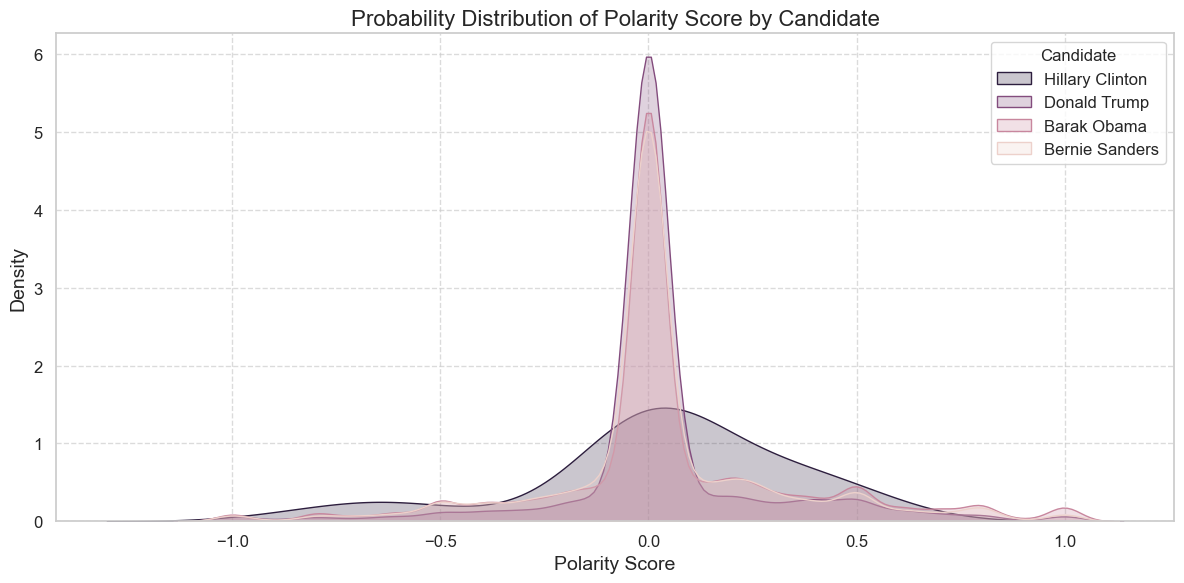

In [234]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=tweets, x='polarity', hue='candidate_id', fill=True, common_norm=False)

plt.title('Probability Distribution of Polarity Score by Candidate', fontsize=16)
plt.xlabel('Polarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Candidate', labels=['Hillary Clinton', 'Donald Trump', 'Barak Obama', 'Bernie Sanders'], fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [276]:
tweets[tweets['polarity'] <-.5]['cleaned_tweet_text'].tolist()

['politico realdonaldtrump hillaryclinton i got five bucks trump tweets something stupid anway',
 'whoisneil__ realdonaldtrump vine wrong',
 'ryangrim realdonaldtrump itsmarlamaples this just dumb youre allowing yourself to lose credibility with your horrible pieces just dumb',
 'also need to add realdonaldtrump to this list stupid bitch httpstcosspjvjzr8c',
 'are you fucking kidding me stfu lying bitch  httpstcohezzruf1tl',
 'patriciacash11 u think everyone is a hate group who cares about borders amp immigration what a bigot fairimmigration realdonaldtrump',
 'msnbc desperation  they know they are going to lose to realdonaldtrump in november  looking for anything they can to cling to  pathetic',
 'mwaqar09 realdonaldtrump hillaryclinton needs it badly httpstcofz17a62iws',
 'realdonaldtrump how do i block this idiot',
 'mwaqar09 realdonaldtrump hillaryclinton needs it badly httpstcofz17a62iws',
 'barackobama save us i wish you could keep saving us our country is getting angry at realdo

In [250]:
pivot_table

candidate_id,1,2,3,4
date,,,,
2016-08-30,-0.302189,-0.331083,-0.337906,NaN
2016-08-31,-0.336861,-0.337416,-0.368022,NaN
2016-09-01,-0.322017,-0.355999,-0.345914,NaN
2017-02-17,-0.469886,-0.357119,-0.277337,-0.55


In [251]:
tweets['date'].value_counts()

2016-08-31    17791
2016-08-30    16160
2017-02-17    11060
2016-09-01    10382
Name: date, dtype: int64

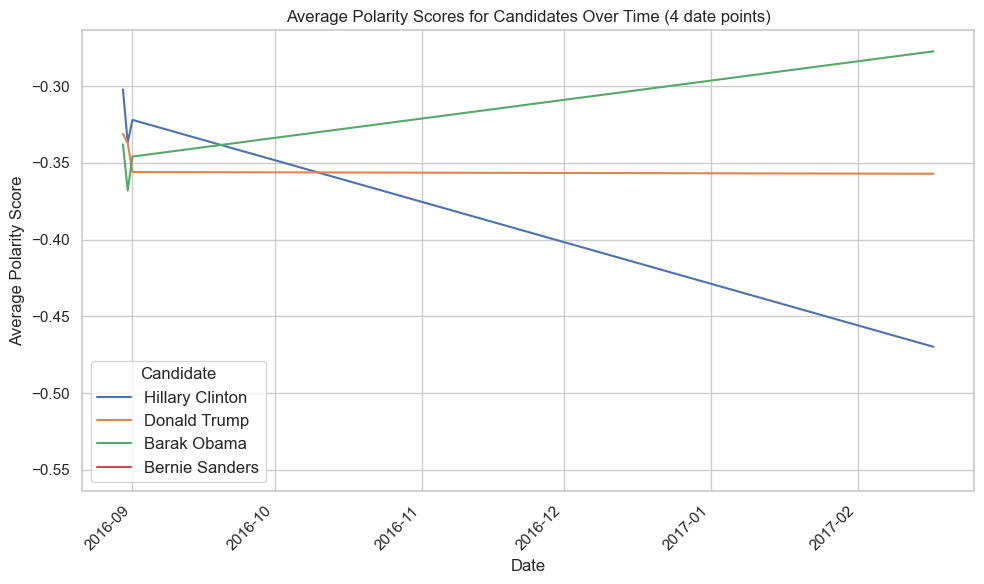

In [252]:
tweets['date'] = pd.to_datetime(tweets['date'])
median_polarity = tweets.groupby('candidate_id')['polarity'].median()

filtered_tweets = pd.DataFrame()
for candidate_id, median_value in median_polarity.items():
    candidate_tweets = tweets[(tweets['candidate_id'] == candidate_id) & (tweets['polarity'] < median_value)]
    filtered_tweets = pd.concat([filtered_tweets, candidate_tweets])

average_polarity_loww = filtered_tweets.groupby(['date', 'candidate_id'])['polarity'].mean().reset_index()

pivot_table = average_polarity_loww.pivot(index='date', columns='candidate_id', values='polarity')

pivot_table.plot(figsize=(10, 6))
plt.title('Average Polarity Scores for Candidates Over Time (4 date points)')
plt.xlabel('Date')
plt.ylabel('Average Polarity Score')
plt.xticks(rotation=45)
plt.legend(title='Candidate', labels=['Hillary Clinton', 'Donald Trump', 'Barak Obama', 'Bernie Sanders'], fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [246]:
median_polarity = tweets.groupby('candidate_id')['polarity'].median()

filtered_tweets = pd.DataFrame()
for candidate_id, median_value in median_polarity.items():
    candidate_tweets = tweets[(tweets['candidate_id'] == candidate_id) & (tweets['polarity'] < median_value)]
    filtered_tweets = pd.concat([filtered_tweets, candidate_tweets])

average_polarity_loww = filtered_tweets.groupby(['date', 'candidate_id'])['polarity'].mean().reset_index()


,date,candidate_id,polarity
0,2016-08-30,1,-0.302189
1,2016-08-30,2,-0.331083
2,2016-08-30,3,-0.337906
3,2016-08-31,1,-0.336861
4,2016-08-31,2,-0.337416
5,2016-08-31,3,-0.368022
6,2016-09-01,1,-0.322017
7,2016-09-01,2,-0.355999
8,2016-09-01,3,-0.345914
9,2017-02-17,1,-0.469886


In [255]:
tweets.columns

Index(['id', 'candidate_id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'tweet_text', 'created_at', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude',
       'cleaned_tweet_text', 'sentiment', 'subset_translated',
       'preprocessed_text', 'date'],
      dtype='object')

/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_96359/1850832925.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_96359/1850832925.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




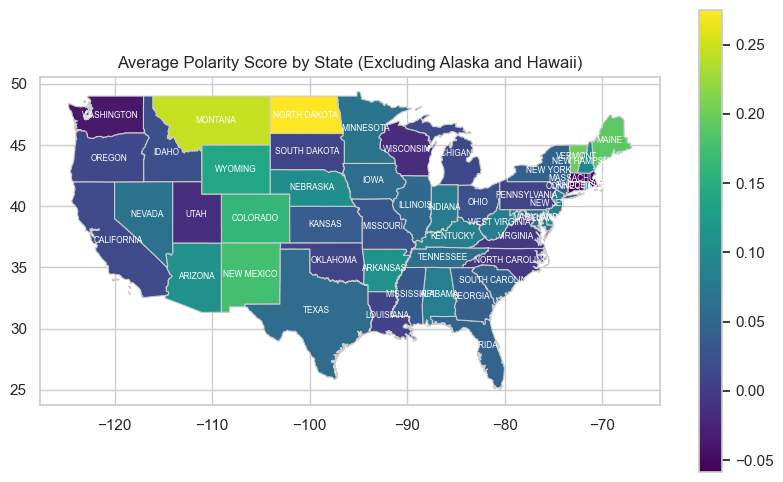

In [279]:
import geopandas as gpd
import matplotlib.pyplot as plt
us_states = gpd.read_file("/Users/susanliang/Desktop/CEU-General/3rd year/Winter/Cyberconflict/Breach Sentiment Analysis/States_shapefile-shp/States_shapefile.shp")
us_states_mainland = us_states[~us_states['State_Name'].isin(['ALASKA', 'HAWAII'])]
merged_data = us_states_mainland.merge(data, left_on='State_Code', right_on='state')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_data.plot(column='polarity', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['State_Name']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center', color='white')
ax.set_title('Average Polarity Score by State (Excluding Alaska and Hawaii)')
plt.show()


In [200]:
tweets['candidate_id'].value_counts()

2    36712
1    14290
3     4366
4       25
Name: candidate_id, dtype: int64

In [313]:
tweets[(tweets['candidate_id'] == 1) & (tweets['state'] == 'NM')]['cleaned_tweet_text'].tolist()

['mikepencevp how easily hillaryclinton forgets  policy changes with the windor votes  take your pick',
 'hillaryclinton how come your hacking the election an blaming russia whitehousehack blamerussia hawhaw',
 'hillaryclinton your cheatin heart will tell on you  from days gone bye your cheatin heart']

In [325]:
russia_involved = tweets[tweets['cleaned_tweet_text'].str.contains('russia', case=False, na=False)]
russia_involved = russia_involved[russia_involved['candidate_id'] == 2]
russia_involved['preprocessed_text'] = russia_involved['tweet_text'].apply(preprocess_text)
dictionary = Dictionary(russia_involved['preprocessed_text'])
dictionary.filter_extremes(no_below=5, no_above=0.4)
corpus = [dictionary.doc2bow(text) for text in russia_involved['preprocessed_text']]

# Train LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=10,
                     passes=10)

for idx, topic in lda_model.print_topics():
    print("Topic {}: {}".format(idx, topic))

coherence_model_lda = CoherenceModel(model=lda_model, texts=russia_involved['preprocessed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Topic 0: 0.129*"us" + 0.075*"russian" + 0.067*"war" + 0.062*"stop" + 0.049*"election" + 0.045*"nothing" + 0.045*"russiagate" + 0.038*"ship" + 0.038*"tillerson" + 0.030*"meet"
Topic 1: 0.113*"uranium" + 0.112*"russian" + 0.066*"media" + 0.059*"clinton" + 0.059*"fight" + 0.052*"press" + 0.041*"selling" + 0.040*"true" + 0.040*"made" + 0.030*"putin"
Topic 2: 0.146*"china" + 0.095*"cnn" + 0.074*"money" + 0.054*"us" + 0.048*"play" + 0.042*"come" + 0.042*"taxes" + 0.041*"lying" + 0.032*"half" + 0.032*"medvedevrussia"
Topic 3: 0.126*"russian" + 0.073*"friends" + 0.071*"ties" + 0.071*"'re" + 0.056*"said" + 0.053*"even" + 0.042*"kellyannepolls" + 0.037*"million" + 0.037*"donald" + 0.030*"putin"
Topic 4: 0.263*"russians" + 0.087*"election" + 0.058*"america" + 0.041*"donald" + 0.040*"blame" + 0.038*"w/" + 0.036*"going" + 0.034*"back" + 0.034*"big" + 0.030*"rig"
Topic 5: 0.087*"hack" + 0.074*"fbi" + 0.051*"let" + 0.045*"...." + 0.040*"take" + 0.039*"putin" + 0.037*"probe" + 0.037*"yes" + 0.032*"rus

In [284]:
excel_file_path = "/Users/susanliang/Desktop/CEU-General/3rd year/Winter/Cyberconflict/Breach Sentiment Analysis/statistic_id630799_election-2016_-results-by-state.xlsx"
sheet_name = "Data"  
states_vote = pd.read_excel(excel_file_path, sheet_name=sheet_name)
states_vote.head()


,States,Abbrv.,Hillary Clinton,Donald Trump,Unnamed: 4
0,Alabama,AL,34.7,62.7,in %
1,Alaska,AK,37.6,52.8,in %
2,Arizona,AZ,45.5,49.0,in %
3,Arkansas,AR,33.7,60.6,in %
4,California,CA,62.3,31.9,in %


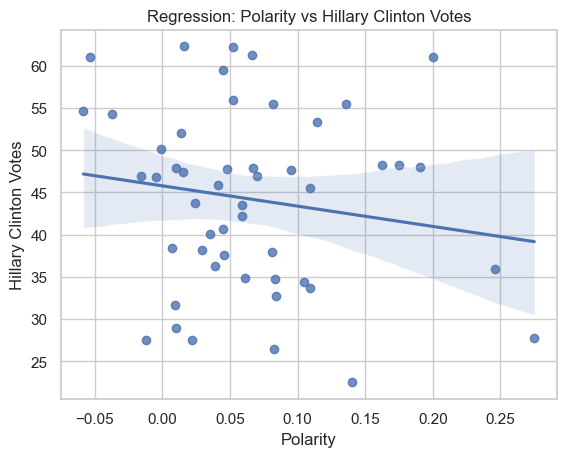

In [286]:
merged_data = pd.merge(states_vote, data, left_on='Abbrv.', right_on='state')
sns.regplot(x='polarity', y='Hillary Clinton', data=merged_data)
plt.xlabel('Polarity')
plt.ylabel('Hillary Clinton Votes')
plt.title('Regression: Polarity vs Hillary Clinton Votes')
plt.show()

In [287]:
correlation = merged_data['polarity'].corr(merged_data['Hillary Clinton'])
correlation

-0.15988359213237638

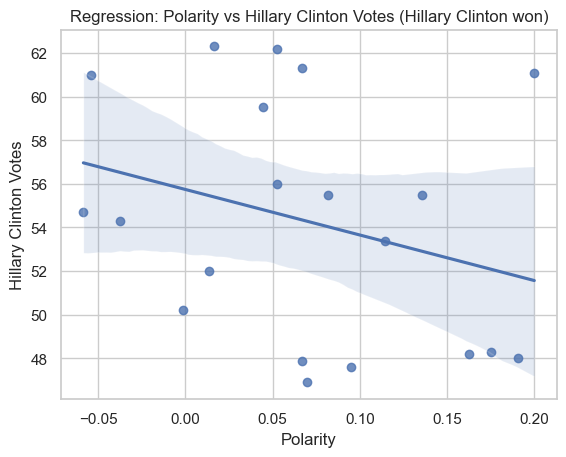

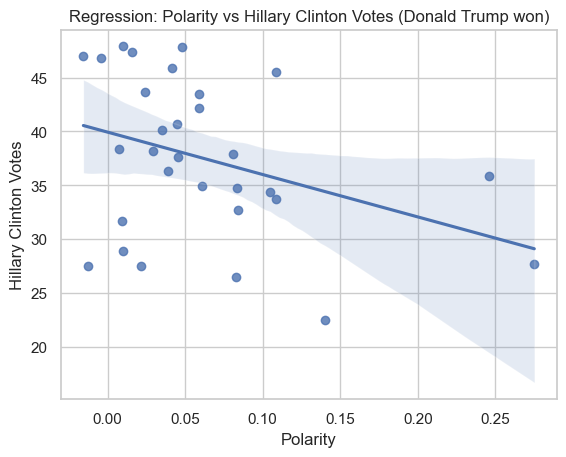

In [289]:
merged_data['Vote_Difference'] = merged_data['Hillary Clinton'] - merged_data['Donald Trump']
clinton_wins_data = merged_data[merged_data['Vote_Difference'] > 0]
trump_wins_data = merged_data[merged_data['Vote_Difference'] <= 0]

sns.regplot(x='polarity', y='Hillary Clinton', data=clinton_wins_data)
plt.xlabel('Polarity')
plt.ylabel('Hillary Clinton Votes')
plt.title('Regression: Polarity vs Hillary Clinton Votes (Hillary Clinton won)')
plt.show()

sns.regplot(x='polarity', y='Hillary Clinton', data=trump_wins_data)
plt.xlabel('Polarity')
plt.ylabel('Hillary Clinton Votes')
plt.title('Regression: Polarity vs Hillary Clinton Votes (Donald Trump won)')
plt.show()

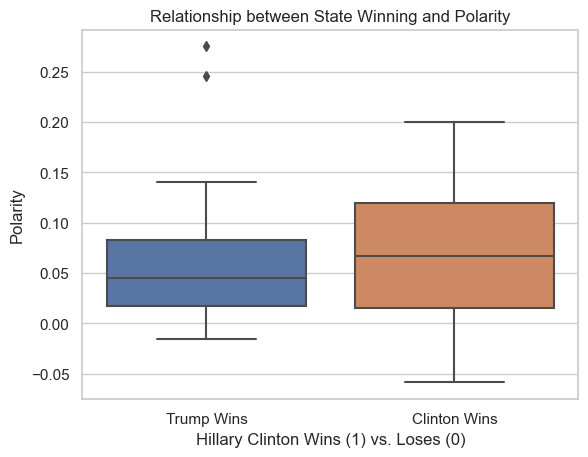

In [290]:
merged_data['Hillary_Wins'] = (merged_data['Hillary Clinton'] > merged_data['Donald Trump']).astype(int)

sns.boxplot(x='Hillary_Wins', y='polarity', data=merged_data)
plt.xlabel('Hillary Clinton Wins (1) vs. Loses (0)')
plt.ylabel('Polarity')
plt.title('Relationship between State Winning and Polarity')
plt.xticks([0, 1], ['Trump Wins', 'Clinton Wins'])
plt.show()

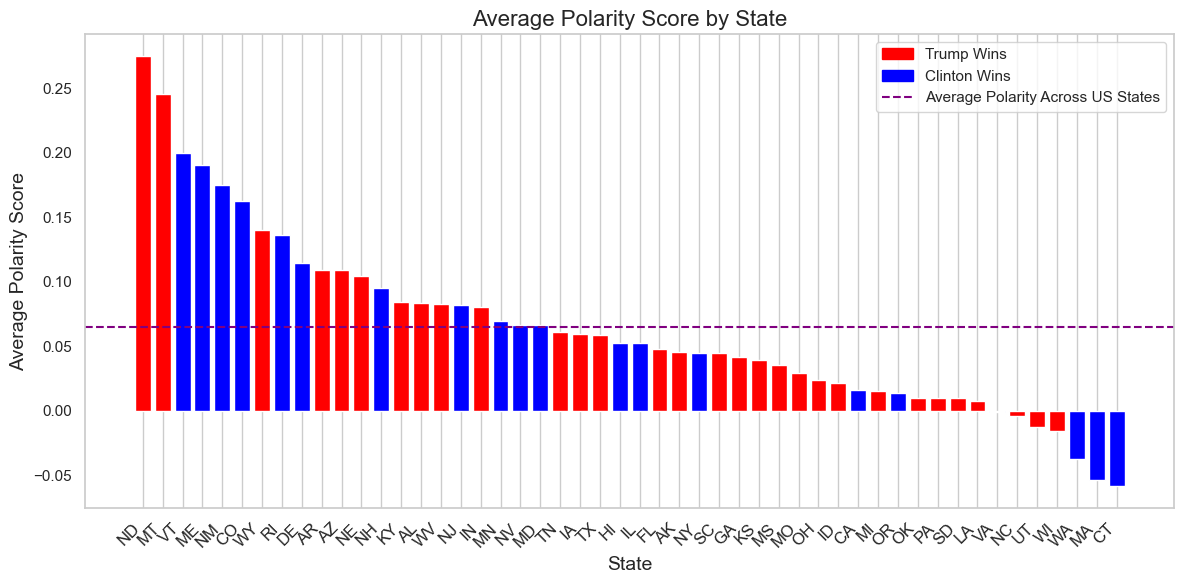

In [306]:
import matplotlib.patches as mpatches

merged_data = pd.merge(average_polarity_by_state_sorted, states_vote, left_on='state', right_on='Abbrv.')

merged_data['Trump_Wins'] = merged_data['Donald Trump'] > merged_data['Hillary Clinton']

colors = ['red' if trump_wins else 'blue' for trump_wins in merged_data['Trump_Wins']]

plt.figure(figsize=(12, 6))
plt.bar(merged_data['state'], merged_data['polarity'], color=colors)
plt.title('Average Polarity Score by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Polarity Score', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y')
red_patch = mpatches.Patch(color='red', label='Trump Wins')
blue_patch = mpatches.Patch(color='blue', label='Clinton Wins')
plt.axhline(y=0.06451856044190958, color='purple', linestyle='--', label='Average Polarity Across US States')
green_line = plt.Line2D([0], [0], color='purple', linestyle='--', label='Average Polarity Across US States')

handles = [red_patch, blue_patch, green_line]
labels = ['Trump Wins', 'Clinton Wins', 'Average Polarity Across US States']

plt.legend(handles=handles, labels=labels, loc='upper right')



plt.tight_layout()
plt.show()


In [299]:
average_polarity_by_state_sorted['polarity'].mean()

0.06451856044190958